# Objetivo hacer preprocesamiento normal (stop words, signos, etc), hacer embeddings con CBOW y entrenar un modelo de ML para predecir el sentimiento.

# CBOW

![](we5.PNG)

## Preparación del entorno

In [123]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error
import re
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Funciones 

In [80]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-zA-Z@#]', ' ', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    text = ' '.join(tokens)
    
    return text

In [81]:
def predict_sentiment(user_input):

    user_input = preprocess_text(user_input)
    
    user_sequence = tokenizer.texts_to_sequences([user_input])
    user_padded_sequence = pad_sequences(user_sequence, maxlen=max_sequence_length)
    
    prediction = model.predict(user_padded_sequence)
    sentiment_label = label_encoder.inverse_transform([np.argmax(prediction)])[0]
    
    return sentiment_label

## Carga de datos

In [82]:
df = pd.read_csv('Corona_NLP_train.csv',encoding='latin1')

In [83]:
df.head(3)

UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   

                                       OriginalTweet Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...   Neutral  
1  advice Talk to your neighbours family to excha...  Positive  
2  Coronavirus Australia: Woolworths to give elde...  Positive

In [84]:
df.Sentiment.unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

## Preprocesamiento

In [85]:
df['OriginalTweet'] = df['OriginalTweet'].apply(preprocess_text)

### Stopwords

In [86]:
stop_words = set(stopwords.words('english'))

In [87]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['OriginalTweet'])
sequences = tokenizer.texts_to_sequences(df['OriginalTweet'])

### Definir longitud de la secuencia

In [88]:
max_sequence_length = max(len(seq) for seq in sequences)
sequences = pad_sequences(sequences, maxlen=max_sequence_length)

### Label Encoder

In [89]:
df.Sentiment.head(2)

0     Neutral
1    Positive
Name: Sentiment, dtype: object

In [90]:
label_encoder = LabelEncoder()

df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])

df.Sentiment.head(2)

0    3
1    4
Name: Sentiment, dtype: int32

### Train Test Split

In [91]:
X_train, X_test, y_train, y_test = train_test_split(sequences, df['Sentiment'], test_size=0.2, random_state=42)

## Entrenamiento

### Entrenamiento del modelo CBOW (Word2Vec)

In [120]:
embedding_dim = 40
model = Word2Vec(sentences=df['OriginalTweet'], vector_size=embedding_dim, window=5, sg=0, min_count=1, workers=4)
model.save("word2vec.model")

### Carga modelo CBOW

In [121]:
word_vectors = Word2Vec.load("word2vec.model")

### Entrenamiento de modelo de clasificación (Red neuronal simple)

In [124]:
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length),
    Flatten(),
    Dense(18, activation='relu'),
    Dropout(0.6),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/100
412/412 [==============================] - 18s 42ms/step - loss: 1.5343 - accuracy: 0.2916 - val_loss: 1.3925 - val_accuracy: 0.4255
Epoch 2/100
412/412 [==============================] - 18s 45ms/step - loss: 1.2149 - accuracy: 0.4862 - val_loss: 1.0496 - val_accuracy: 0.6006
Epoch 3/100
412/412 [==============================] - 18s 43ms/step - loss: 0.8779 - accuracy: 0.6531 - val_loss: 0.9770 - val_accuracy: 0.6276
Epoch 4/100
412/412 [==============================] - 15s 37ms/step - loss: 0.6661 - accuracy: 0.7446 - val_loss: 1.0025 - val_accuracy: 0.6220
Epoch 5/100
412/412 [==============================] - 16s 38ms/step - loss: 0.5276 - accuracy: 0.7974 - val_loss: 1.0813 - val_accuracy: 0.6137
Epoch 6/100
412/412 [==============================] - 15s 36ms/step - loss: 0.4271 - accuracy: 0.8328 - val_loss: 1.1502 - val_accuracy: 0.6135
Epoch 7/100
412/412 [==============================] - 15s 36ms/step - loss: 0.3707 - accuracy: 0.8593 - val_loss: 1.2730 - val_ac

## Evaluación del modelo

In [125]:
y_pred = model.predict(X_train)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_train, y_pred_classes)
roc_auc = roc_auc_score(y_train, y_pred, average='macro', multi_class='ovr')  # Set multi_class to 'ovr'
mse = mean_squared_error(y_train, y_pred_classes)

print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"Mean Squared Error: {mse}")

1029/1029 [==============================] - 2s 1ms/step
Accuracy: 0.8456795747911922
ROC AUC: 0.9670319952251308
Mean Squared Error: 0.6621412300683371


In [126]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
roc_auc = roc_auc_score(y_test, y_pred, average='macro', multi_class='ovr')  # Set multi_class to 'ovr'
mse = mean_squared_error(y_test, y_pred_classes)

print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"Mean Squared Error: {mse}")

258/258 [==============================] - 0s 1ms/step
Accuracy: 0.6229348882410107
ROC AUC: 0.8745320571832664
Mean Squared Error: 1.6034985422740524


### Prueba

In [127]:
user_input = "I can´t beleive this you are unreal"

predicted_sentiment = predict_sentiment(user_input)

print(f"Predicted Sentiment: {predicted_sentiment}")

1/1 [==============================] - 0s 30ms/step
Predicted Sentiment: Neutral


# PCA

In [128]:
# Extract word embeddings using Word2Vec
word_vectors = Word2Vec.load("word2vec.model")

In [129]:
def average_sequence_embeddings(sequences, word_vectors):
    avg_embeddings = []
    for seq in sequences:
        embeddings = get_sequence_embeddings(seq, word_vectors)
        if embeddings:
            avg_embeddings.append(np.mean(embeddings, axis=0))
        else:
            # Handle empty embeddings as needed
            avg_embeddings.append(np.zeros(embedding_dim))
    return np.array(avg_embeddings)

In [130]:
X_avg_embeddings = average_sequence_embeddings(sequences, word_vectors)

In [131]:
# PCA for data before the model
pca_before = PCA(n_components=2)
X_pca_before = pca_before.fit_transform(X_avg_embeddings)

In [132]:
# PCA for data after the model
X_test_avg_embeddings = average_sequence_embeddings(X_test, word_vectors)
X_pca_after = pca_before.transform(X_test_avg_embeddings)

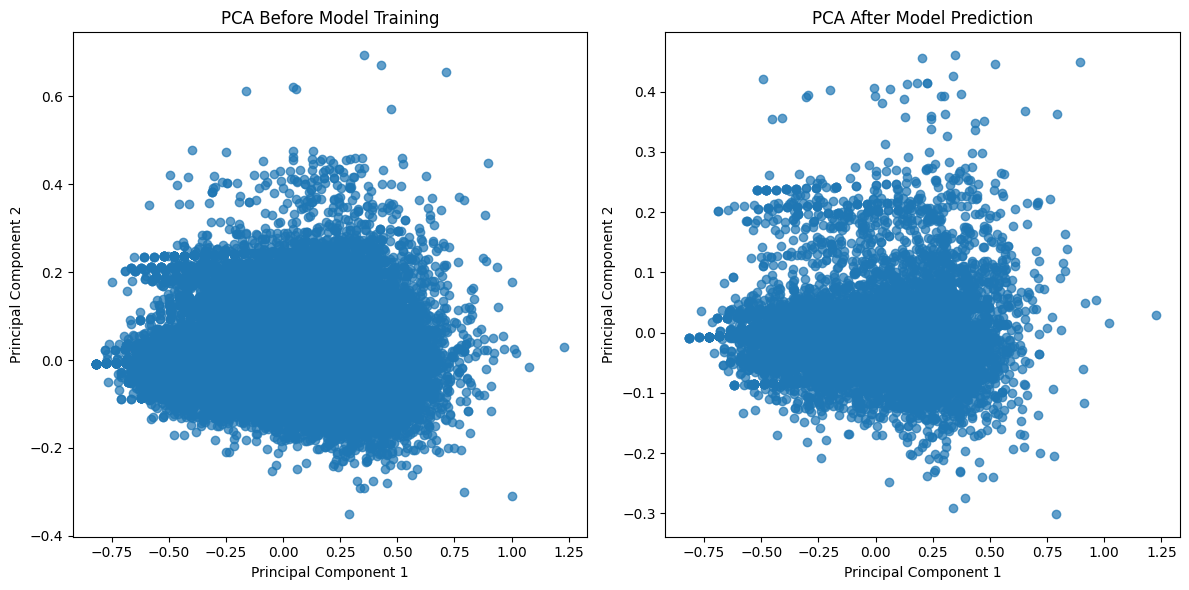

In [133]:
# Plot PCA results


plt.figure(figsize=(12, 6))

# PCA Before Model Training
plt.subplot(1, 2, 1)
plt.scatter(X_pca_before[:, 0], X_pca_before[:, 1], alpha=0.7)
plt.title('PCA Before Model Training')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# PCA After Model Prediction
plt.subplot(1, 2, 2)
plt.scatter(X_pca_after[:, 0], X_pca_after[:, 1], alpha=0.7)
plt.title('PCA After Model Prediction')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

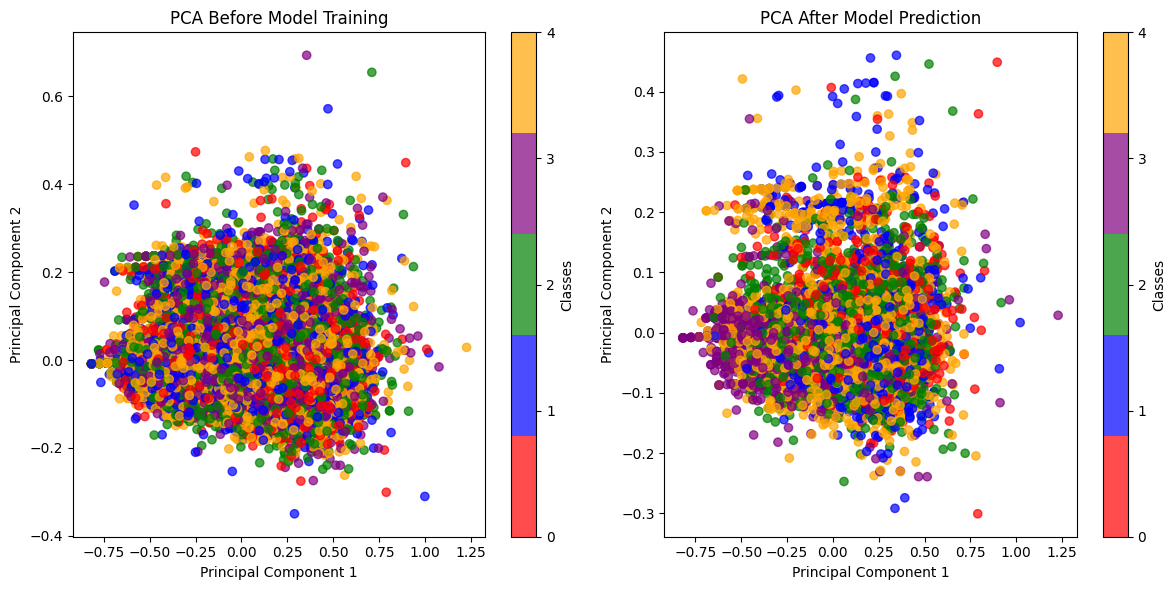

In [134]:
# Create a subset of data and labels for plotting with PCA
subset_size = 30000  # Choose an appropriate subset size based on your dataset
X_train_subset = X_pca_before[:subset_size]
y_train_subset = y_train[:subset_size]

# Define a colormap with 5 distinct colors, one for each class
class_colors = ['red', 'blue', 'green', 'purple', 'orange']
cmap = ListedColormap(class_colors)

# Plot PCA Before Model Training
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_train_subset[:, 0], X_train_subset[:, 1], c=y_train_subset, cmap=cmap, alpha=0.7)
plt.title('PCA Before Model Training')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(ticks=[0, 1, 2, 3, 4], label='Classes')

# Plot PCA After Model Prediction
plt.subplot(1, 2, 2)
# Assuming you have a similar subset of X_pca_after and y_pred_classes
X_pca_after_subset = X_pca_after[:subset_size]
y_pred_classes_subset = y_pred_classes[:subset_size]
plt.scatter(X_pca_after_subset[:, 0], X_pca_after_subset[:, 1], c=y_pred_classes_subset, cmap=cmap, alpha=0.7)
plt.title('PCA After Model Prediction')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(ticks=[0, 1, 2, 3, 4], label='Classes')

plt.tight_layout()
plt.show()


# PCA 3 componentes

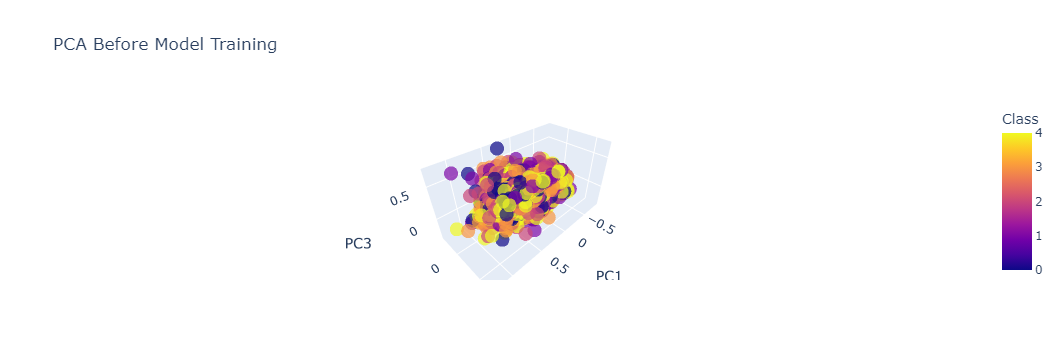

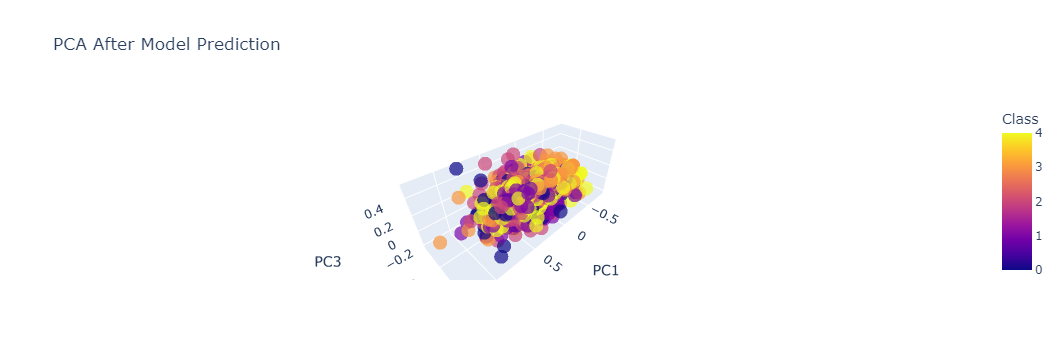

In [135]:
import plotly.express as px

# PCA for data before the model with 3 components
pca_before = PCA(n_components=3)
X_pca_before = pca_before.fit_transform(X_avg_embeddings)

# PCA for data after the model with 3 components
X_pca_after = pca_before.transform(X_test_avg_embeddings)

# Create a subset of data and labels for plotting with PCA
subset_size = 30000  # Choose an appropriate subset size based on your dataset
X_train_subset = X_pca_before[:subset_size]
y_train_subset = y_train[:subset_size]
X_test_subset = X_pca_after[:subset_size]
y_pred_classes_subset = y_pred_classes[:subset_size]

# Create a DataFrame for PCA Before Model Training
df_before = pd.DataFrame({'PC1': X_train_subset[:, 0], 'PC2': X_train_subset[:, 1], 'PC3': X_train_subset[:, 2], 'Class': y_train_subset})

# Create a DataFrame for PCA After Model Prediction
df_after = pd.DataFrame({'PC1': X_test_subset[:, 0], 'PC2': X_test_subset[:, 1], 'PC3': X_test_subset[:, 2], 'Class': y_pred_classes_subset})

# Create interactive 3D scatter plots
fig_before = px.scatter_3d(df_before, x='PC1', y='PC2', z='PC3', color='Class', title='PCA Before Model Training', opacity=0.7)
fig_after = px.scatter_3d(df_after, x='PC1', y='PC2', z='PC3', color='Class', title='PCA After Model Prediction', opacity=0.7)

# Show the plots
fig_before.show()
fig_after.show()


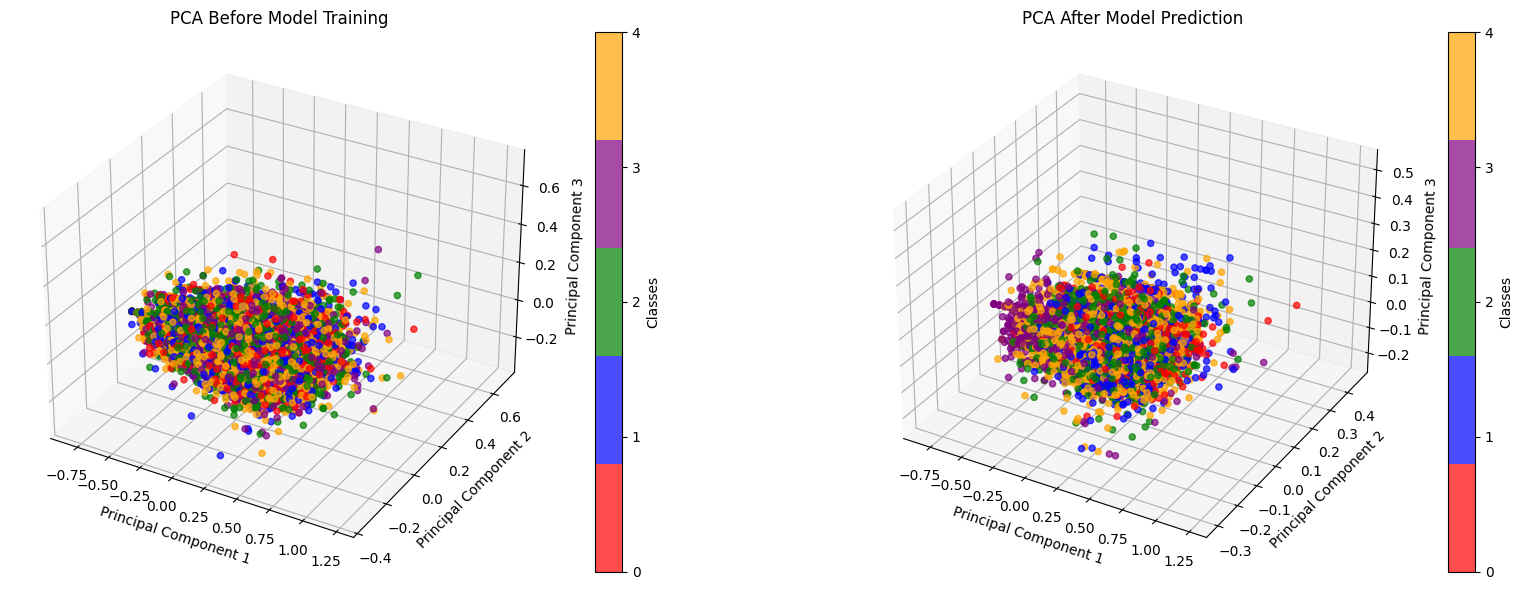

In [136]:
from mpl_toolkits.mplot3d import Axes3D

# PCA for data before the model with 3 components
pca_before = PCA(n_components=3)
X_pca_before = pca_before.fit_transform(X_avg_embeddings)

# PCA for data after the model with 3 components
X_pca_after = pca_before.transform(X_test_avg_embeddings)

# Create a subset of data and labels for plotting with PCA
subset_size = 30000  # Choose an appropriate subset size based on your dataset
X_train_subset = X_pca_before[:subset_size]
y_train_subset = y_train[:subset_size]

# Define a colormap with 5 distinct colors, one for each class
class_colors = ['red', 'blue', 'green', 'purple', 'orange']
cmap = ListedColormap(class_colors)

# Create a 3D plot for PCA Before Model Training
fig = plt.figure(figsize=(18, 6))

ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(X_train_subset[:, 0], X_train_subset[:, 1], X_train_subset[:, 2], c=y_train_subset, cmap=cmap, alpha=0.7)
ax1.set_title('PCA Before Model Training')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.set_zlabel('Principal Component 3')
fig.colorbar(scatter1, ax=ax1, ticks=[0, 1, 2, 3, 4], label='Classes')

# Create a 3D plot for PCA After Model Prediction
ax2 = fig.add_subplot(122, projection='3d')
# Assuming you have a similar subset of X_pca_after and y_pred_classes
X_pca_after_subset = X_pca_after[:subset_size]
y_pred_classes_subset = y_pred_classes[:subset_size]
scatter2 = ax2.scatter(X_pca_after_subset[:, 0], X_pca_after_subset[:, 1], X_pca_after_subset[:, 2], c=y_pred_classes_subset, cmap=cmap, alpha=0.7)
ax2.set_title('PCA After Model Prediction')
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.set_zlabel('Principal Component 3')
fig.colorbar(scatter2, ax=ax2, ticks=[0, 1, 2, 3, 4], label='Classes')

plt.tight_layout()
plt.show()
